# Dirichlet mixture of multinomial distributions for HTTP Error Codes

## The problem


Links that helped me build this:
1. https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns

In [2]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(true_frac)  # Number of different tree species observed
n = 10  # Number of forests observed
total_count = 50

true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

observed_counts

array([[34,  7,  3,  6,  0],
       [31,  7,  5,  6,  1],
       [12, 17, 19,  2,  0],
       [42,  4,  0,  4,  0],
       [16, 31,  0,  3,  0],
       [28, 14,  4,  4,  0],
       [ 8, 39,  1,  2,  0],
       [14, 17, 10,  9,  0],
       [28,  7,  7,  8,  0],
       [14, 17, 19,  0,  0]])

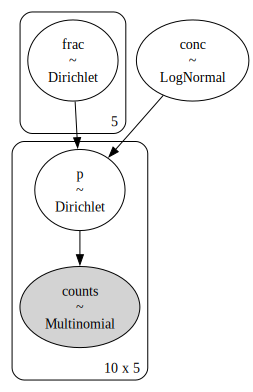

In [5]:
with pm.Model() as model_dm_marginalized:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial(
        "counts", n=total_count, a=frac * conc, shape=(n, k), observed=observed_counts
    )

pm.model_to_graphviz(model_dm_marginalized)



pm.model_to_graphviz(model_dm_explicit)


In [6]:
with model_dm_marginalized:
    trace_dm_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


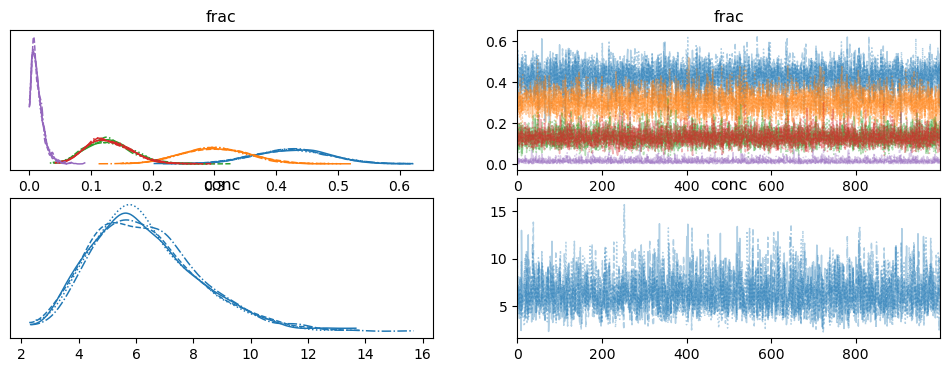

In [7]:
az.plot_trace(data=trace_dm_marginalized, var_names=["frac", "conc"]);

In [9]:
summary_multinomial = az.summary(trace_dm_marginalized, var_names=["frac", "conc"])
#summary_multinomial = summary_multinomial.assign(
#    ess_mean_per_sec=lambda x: x.ess_mean / trace_multinomial.posterior.sampling_time,
#)

summary_multinomial


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
frac[0],0.424,0.060,0.308,0.534,0.001,0.001,5202.0,2817.0,1.0
frac[1],0.302,0.054,0.199,0.398,0.001,0.001,5404.0,2871.0,1.0
frac[2],0.130,0.037,0.065,0.197,0.001,0.000,4698.0,2939.0,1.0
frac[3],0.130,0.036,0.068,0.197,0.001,0.000,3429.0,2647.0,1.0
frac[4],0.014,0.010,0.000,0.032,0.000,0.000,2618.0,2342.0,1.0
conc,6.349,1.910,3.269,10.106,0.033,0.024,3394.0,3219.0,1.0


c:\Users\pboeh\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\pboeh\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


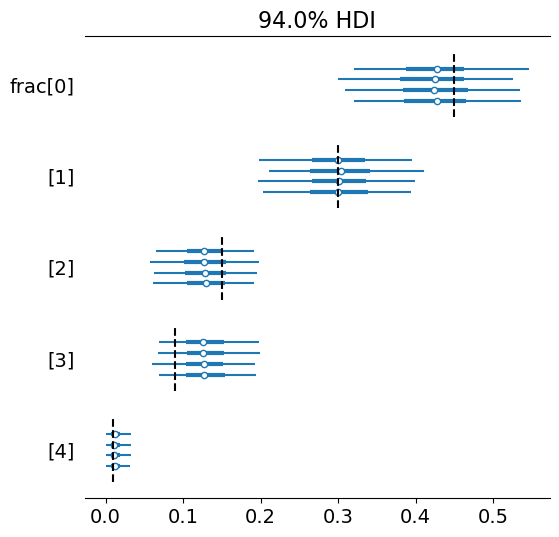

In [11]:
az.plot_forest(trace_dm_marginalized, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

In [13]:
with pm.Model() as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    counts = pm.Multinomial("counts", n=total_count, p=frac, shape=(n, k), observed=observed_counts)

pm.model_to_graphviz(model_multinomial)

with model_multinomial:
    trace_multinomial = pm.sample(
        draws=int(5e3), chains=4, step=pm.Metropolis(), return_inferencedata=True
    )



Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [frac]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [14]:
az.compare(
    {"multinomial": trace_multinomial, "dirichlet_multinomial": trace_dm_marginalized}, ic="loo"
)

TypeError: Encountered error in ELPD computation of compare.